<a href="https://colab.research.google.com/github/ahhCrap/GAN-TUBerlin/blob/master/forked_keras_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fokred from https://github.com/eriklindernoren/Keras-GAN/blob/master/dcgan/dcgan.py

In [0]:
import numpy as np
from matplotlib import pyplot as plt



        
class PMetrics():
    def __init__(self, gan, x_test):
        self.gan = gan
        self.x_test = x_test
        self.z_test = gan.prior(len(x_test))
        self.p_fake, self.fake_std = [], []
        self.p_real, self.real_std = [], []
        
    def track(self, *ignored_args, **ignored_kwargs):
        y_fake = self.gan.D.predict(self.gan.G(self.z_test))
        y_real = self.gan.D.predict(self.x_test)
        self.p_fake += [y_fake.mean()]
        self.p_real += [y_real.mean()]
        self.fake_std += [y_fake.std()]
        self.real_std += [y_real.std()]
        
    def plot(self, *ignored_args, **ignored_kwargs):
        epochs = range(len(self.p_fake))
        plt.errorbar(epochs, self.p_fake, self.fake_std, label='D(G(z))', color='blue')
        #plt.plot(epochs, np.array(self.p_fake) + np.array(self.fake_std), '--', color='blue')
        #plt.plot(epochs, np.array(self.p_fake) - np.array(self.fake_std), '--', color='blue')
        plt.errorbar(epochs, self.p_real, self.real_std, label='D(x)', color='orange', alpha=0.75)
        #plt.plot(epochs, np.array(self.p_real) + np.array(self.real_std), '--', color='orange')
        #plt.plot(epochs, np.array(self.p_real) - np.array(self.real_std), '--', color='orange')
        plt.title('P(real)')
        plt.xlabel('Epoch')
        plt.legend()
        plt.show()



def show(images):
    images = np.reshape(images, [-1, 28, 28])
    n = images.shape[0]
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(n, 2),
                                    sharex=True, sharey=True)
    for i, img, ax in zip(range(n), images, axes):
        ax.imshow((img+1)/2, cmap='Greys')
        ax.axis('off')
    plt.show()
    

class EvolvingImageCallback():
    def __init__(self, gan):
        self.gan = gan
        self.z = gan.prior(10) # for plotting how the projection evolves
        
    def plot(self):
        fakes = self.gan.G(self.z)
        show(fakes)


class Evolving2DCallback():
    def __init__(self, gan):
        self.gan = gan
        self.z = gan.prior(100) # for plotting how the projection evolves
        self.z_at_epoch = [gan.G(self.z)]
    
    def track(self):
        self.z_at_epoch += [self.gan.G(self.z)]
        
    def plot(self):
        t = np.stack(self.z_at_epoch, axis=0)
        epochs = len(self.z_at_epoch)
        plt.clf()
        plt.plot(x[:,0], x[:,1], 'o')
        for p in range(t.shape[1]):
            plt.plot(t[:,p,0], t[:,p,1], alpha=0.5, color='orange')
        plt.plot(t[-1,:,0], t[-1,:,1], 'o', color='red')
        plt.title(f"Epoch {epochs}")
        plt.show()

In [2]:
import tensorflow as tf
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()
from tensorflow.keras.datasets import mnist
# Load the dataset
(X_train, _), (X_test, _) = mnist.load_data()

# Rescale -1 to 1
X_train = X_train / 127.5 - 1.

X_train = np.reshape(X_train, [-1, 28, 28, 1])
X_test = np.reshape(X_test, [-1, 28, 28, 1])

X_train.shape

(60000, 28, 28, 1)

In [0]:
from __future__ import print_function, division

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam


import matplotlib.pyplot as plt

import sys

import numpy as np



def batches(x, batch_size):
    """
    :x: shape (N, d)
    :return: Yields batches
    """
    x = x[np.random.permutation(len(x))][:int(len(x)/batch_size)*batch_size]
    for i in range(0, len(x), batch_size):
        yield x[i:i+batch_size]

        
        
class DCGAN():
    def __init__(self, prior, img_shape=(28, 28, 1), load_from=None):
        self.img_shape = img_shape
        self.channels = img_shape[-1]
        self.latent_dim = 100
        self.prior = prior
        
          

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        self.G = self.generator
        self.D = self.discriminator
        
        
        if load_from:
          self.generator.load_weights(load_from+"_g.h5")
          self.discriminator.load_weights(load_from+"_d.h5")

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.prior.d))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.prior.d,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, X_train, epochs, batch_size=128, callbacks=[]):

        X_train = np.reshape(X_train, [-1]+list(self.img_shape))

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            for batch_id, imgs in enumerate(batches(X_train, batch_size)):
              print(batch_id, '.', end='')

              # Sample noise and generate a batch of new images
              noise = self.prior(batch_size)
              gen_imgs = self.generator.predict(noise)
              fakes_val = gen_imgs[:10]

              # Train the discriminator (real classified as ones and generated as zeros)
              d_loss_real = self.discriminator.train_on_batch(imgs, valid)
              d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
              d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

              #assert np.allclose(self.generator.predict(noise)[:10], fakes_val), "D update effects G"

              # ---------------------
              #  Train Generator
              # ---------------------

              # Train the generator (wants discriminator to mistake images as real)
              y_val = self.discriminator.predict(imgs[:10])
              g_loss = self.combined.train_on_batch(noise, valid)
              #assert np.allclose(y_val, self.discriminator.predict(imgs[:10])), "G update effects D"

            # Plot the progress
            print ("\n%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            for callback, period in callbacks:
              if (epoch+1) % period == 0:
                callback()
    
    def save(self, file_prefix='dcgan'):
        self.generator.save_weights(f"{file_prefix}_g.h5")
        self.discriminator.save_weights(f"{file_prefix}_d.h5")

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/mnist_%d.png" % epoch)
        plt.close()



class Uniform():
    def __init__(self, d=100):
        self.d = d
    
    def __call__(self, n):
        return np.random.uniform(low=-1, high=1, size=(n, self.d))

In [0]:

class InterpolationCallback(EvolvingImageCallback):
    def __init__(self, gan):
        self.gan = gan
        z = gan.prior(2) # for plotting how the projection evolves
        b = z[0][None,...]
        a = z[1][None,...] - b
        x = np.arange(0, 1.05, 0.1)[...,None]
        self.z = a*x + b

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_v2_5 (Ba (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 64)         

W0604 22:03:08.333056 140676068661120 training.py:2131] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
W0604 22:03:11.193815 140676068661120 training.py:2131] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .217 .218 .219 .220 .221 .222

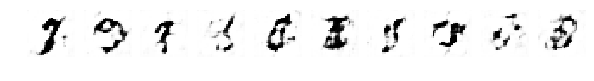

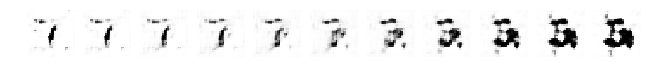

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

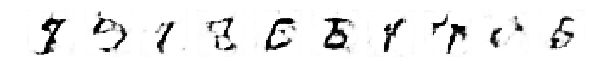

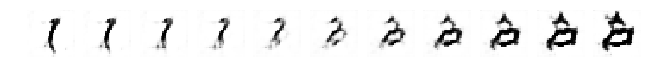

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

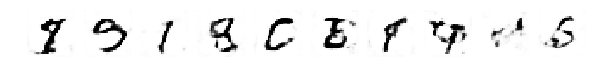

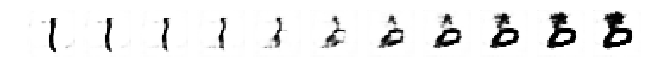

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

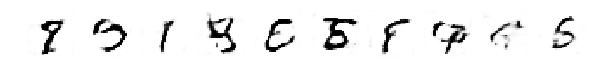

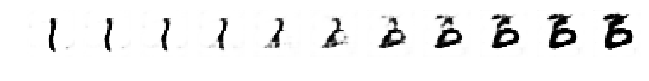

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

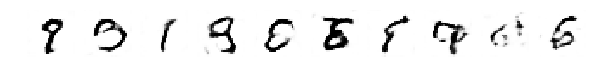

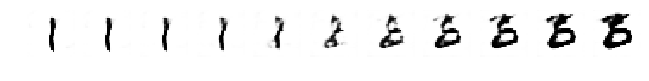

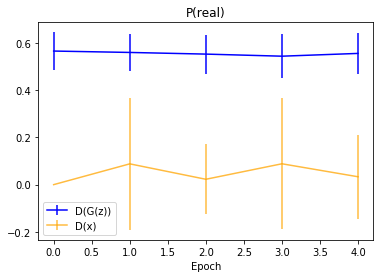

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

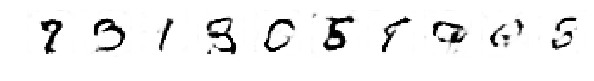

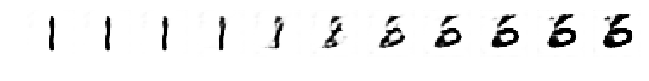

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

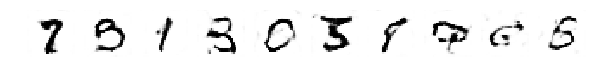

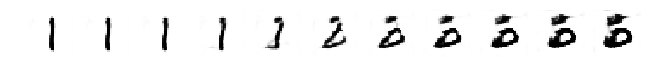

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

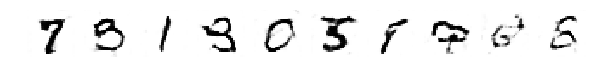

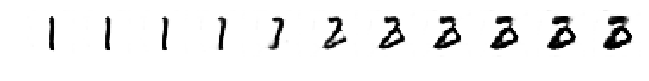

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

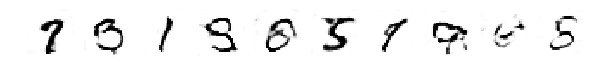

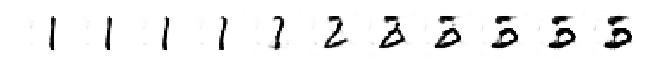

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

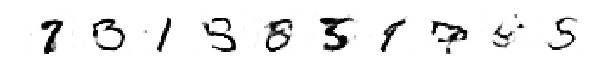

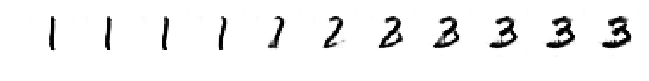

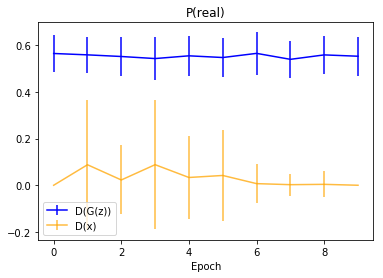

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .217 .218 .219 .220 .221 .222 .223 .224 .225 .226 .227 .228 .

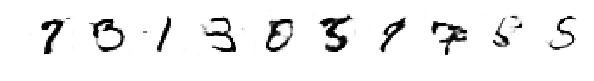

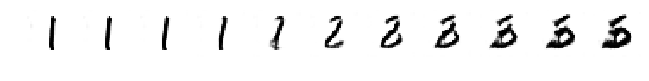

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

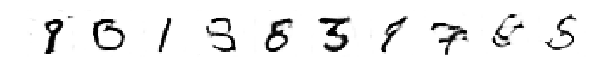

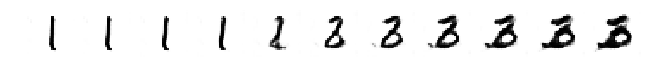

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

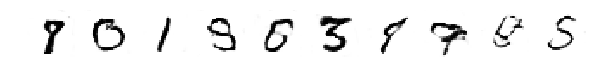

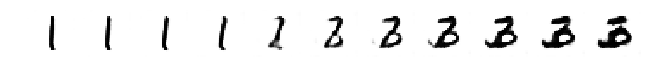

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

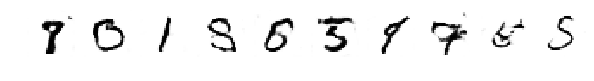

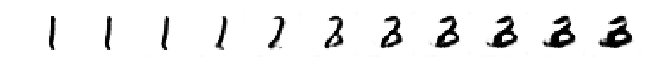

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

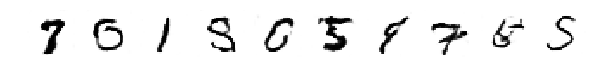

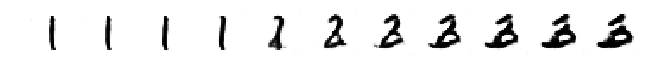

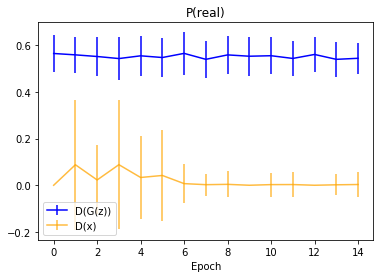

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

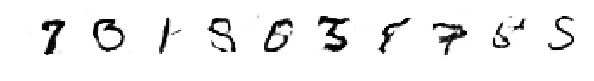

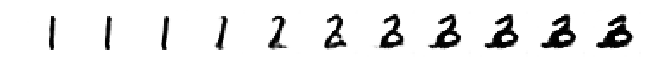

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

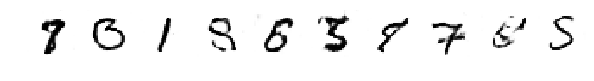

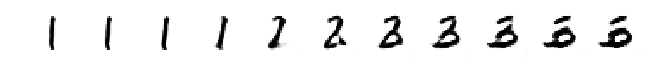

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

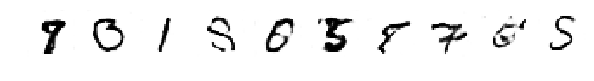

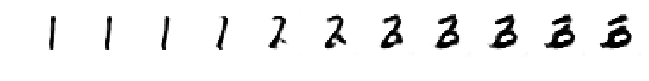

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

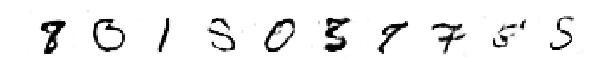

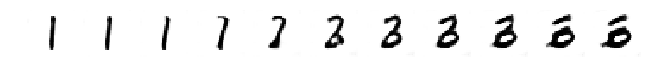

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

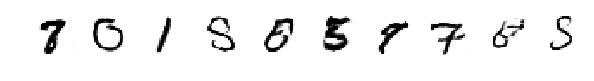

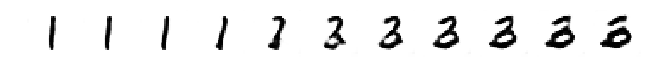

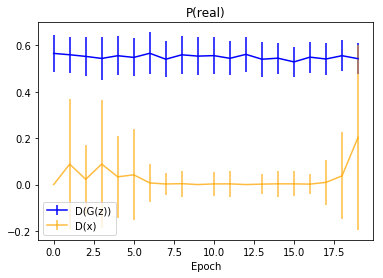

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

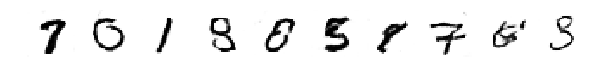

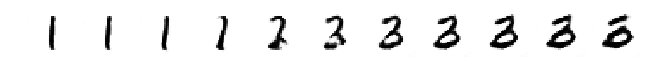

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

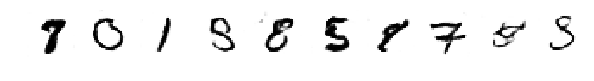

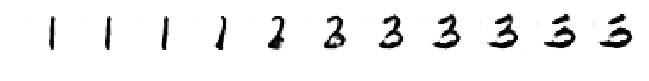

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

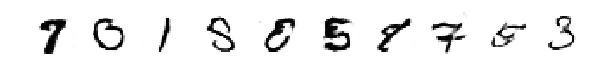

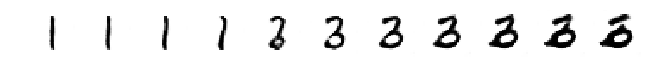

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

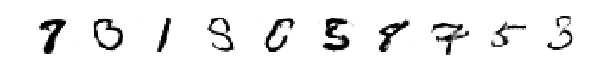

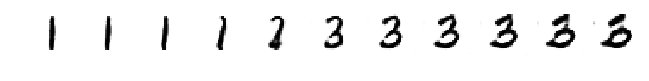

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

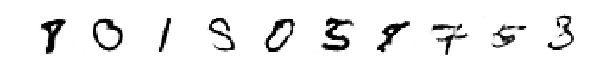

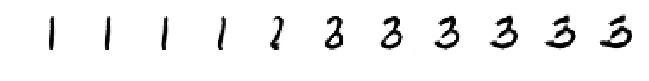

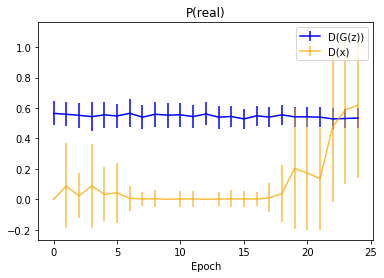

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

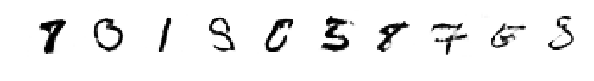

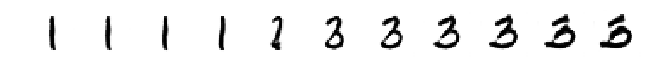

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

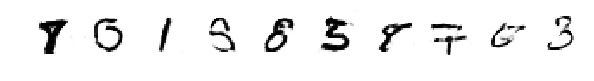

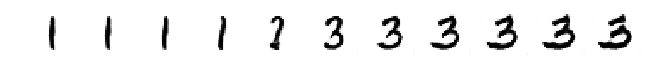

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

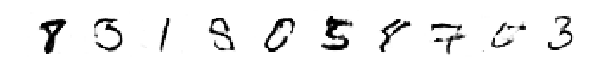

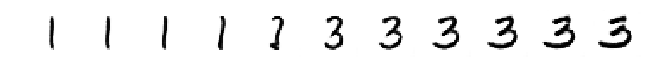

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

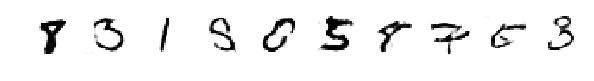

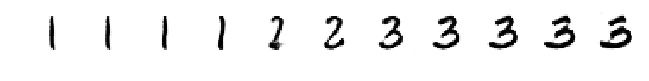

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

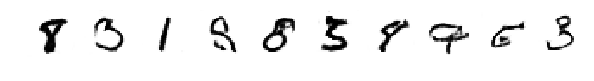

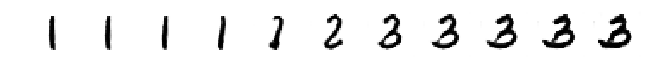

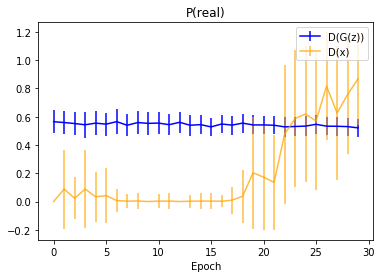

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

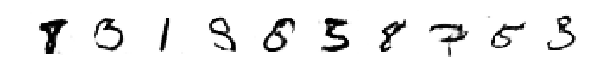

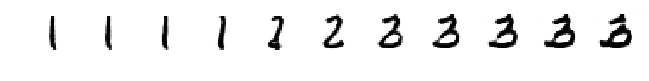

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

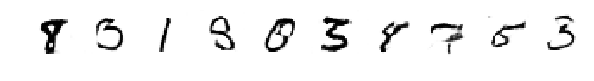

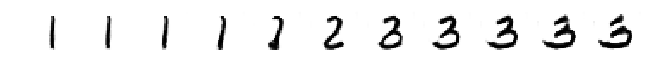

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

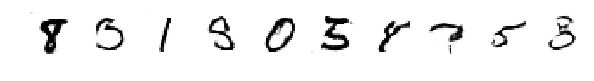

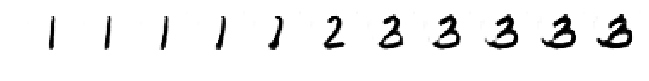

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

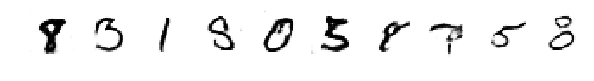

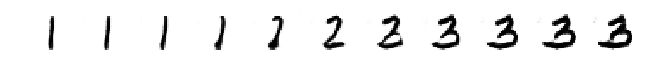

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

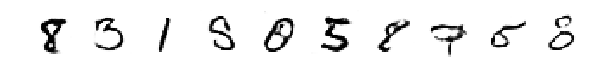

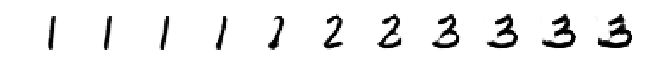

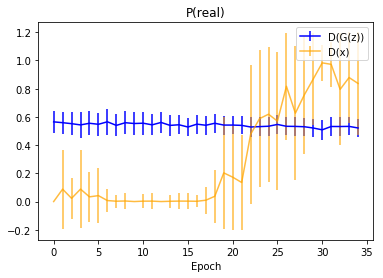

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

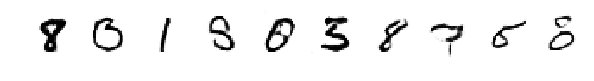

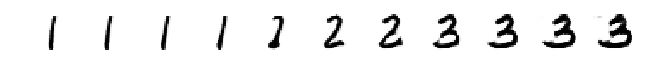

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

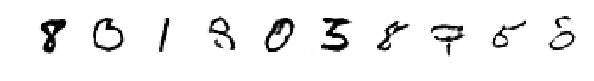

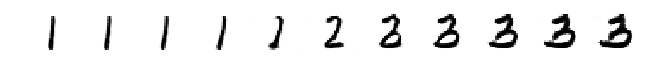

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

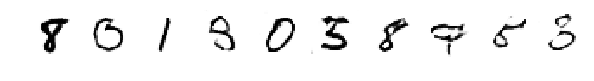

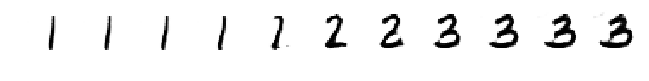

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

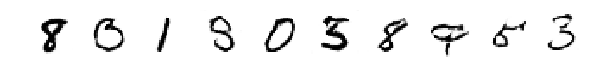

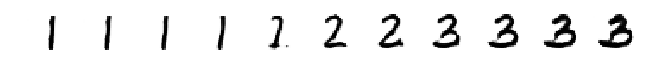

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

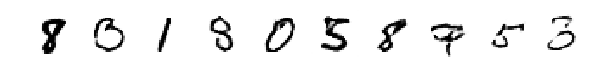

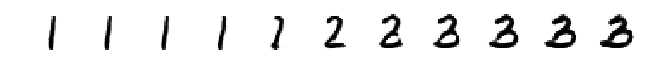

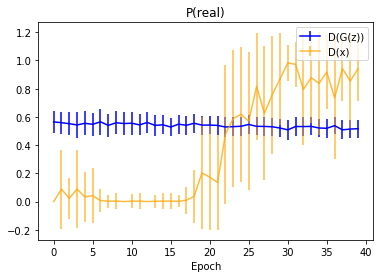

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

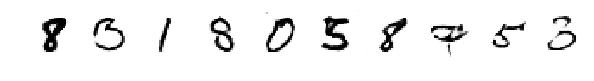

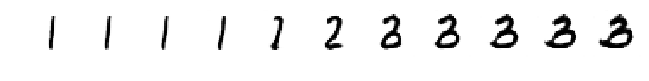

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

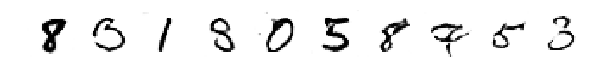

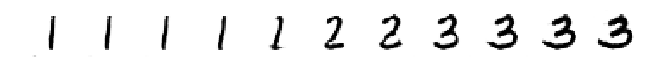

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

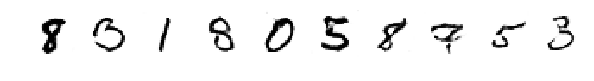

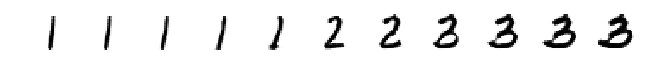

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .94 .95 .96 .97 .98 .99 .100 .101 .102 .103 .104 .105 .106 .107 .108 .109 .110 .111 .112 .113 .114 .115 .116 .117 .118 .119 .120 .121 .122 .123 .124 .125 .126 .127 .128 .129 .130 .131 .132 .133 .134 .135 .136 .137 .138 .139 .140 .141 .142 .143 .144 .145 .146 .147 .148 .149 .150 .151 .152 .153 .154 .155 .156 .157 .158 .159 .160 .161 .162 .163 .164 .165 .166 .167 .168 .169 .170 .171 .172 .173 .174 .175 .176 .177 .178 .179 .180 .181 .182 .183 .184 .185 .186 .187 .188 .189 .190 .191 .192 .193 .194 .195 .196 .197 .198 .199 .200 .201 .202 .203 .204 .205 .206 .207 .208 .209 .210 .211 .212 .213 .214 .215 .216 .

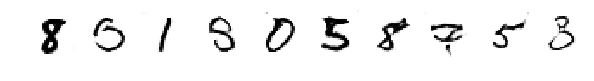

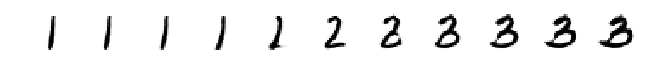

epoch and callbacks done
0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .10 .11 .12 .13 .14 .15 .16 .17 .18 .19 .20 .21 .22 .23 .24 .25 .26 .27 .28 .29 .30 .31 .32 .33 .34 .35 .36 .37 .38 .39 .40 .41 .42 .43 .44 .45 .46 .47 .48 .49 .50 .51 .52 .53 .54 .55 .56 .57 .58 .59 .60 .61 .62 .63 .64 .65 .66 .67 .68 .69 .70 .71 .72 .73 .74 .75 .76 .77 .78 .79 .80 .81 .82 .83 .84 .85 .86 .87 .88 .89 .90 .91 .92 .93 .

KeyboardInterrupt: ignored

In [5]:
gan = DCGAN(Uniform())

        

pmetric = PMetrics(gan, X_test[:1000])
callbacks = [
    (EvolvingImageCallback(gan).plot, 1),
    (InterpolationCallback(gan).plot, 1),
    (pmetric.track, 1),
    (pmetric.plot, 5),
    (lambda: gan.save('models_mnist'), 5),
    (lambda: print('epoch and callbacks done'), 1)
]
  
#gan.train(X_train, epochs=100, batch_size=128, callbacks=callbacks)

Train


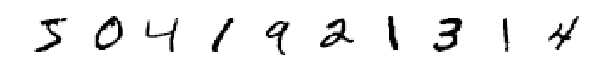

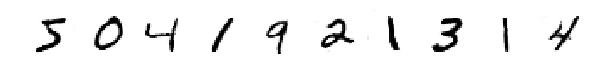

Test


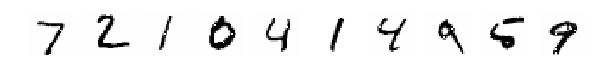

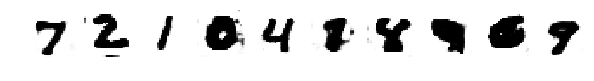

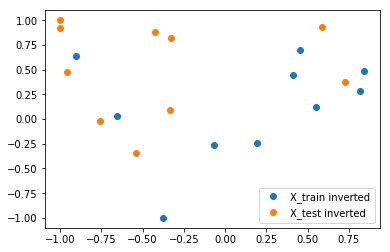

In [83]:
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from scipy.spatial.distance import cdist

#gan = DCGAN(Uniform(), load_from='models_mnist')
g = gan.generator
n = 1000
x = X_test[:n]


class GradientInverser():
  def __init__(self, gan):
    self.gan = gan
    g = gan.generator
    z = Input([gan.prior.d])
    reals = Input(gan.img_shape)
    fakes = g(z)
    loss = K.square(g.outputs[0]-reals)
    gradient = K.gradients(loss, g.inputs[0])[0]
    self.iterate = K.function([g.inputs[0], reals], [loss, gradient])

  def invert(self, x):
    z = gan.prior(1000)
    fakes = gan.generator.predict(z).reshape([1000, -1])
    x_ = x.reshape([-1, fakes.shape[1]])
    z=z[cdist(fakes, x.reshape([-1, fakes.shape[1]])).argmin(0)]
    lr = z*0+0.1
    momentum = 0.5
    old_gradient = 0
    for i in range(40):
      loss, gradient = iterate([z, x])
      gradient = (1-momentum)*gradient + momentum*old_gradient
      old_gradient = gradient
      loss = np.sum(loss, axis=(1, 2, 3))[...,None]
      new_z = z - lr*gradient
      new_z = np.clip(new_z, -1, 1)
      new_loss, _ = iterate([new_z, x])
      new_loss = np.sum(new_loss, axis=(1, 2, 3))[...,None]
      z = np.where(new_loss<loss, new_z, z+np.random.normal(0, 0.01, z.shape))
      lr = np.where(new_loss>loss, lr/2, lr*1.1)*0.9
    return z
  
  
z_train = GradientInverser(gan).invert(X_train[:10])
print("Train")
show(X_train[:10])
show(gan.G.predict(z_train))

z_test = GradientInverser(gan).invert(X_test[:10])
print("Test")
show(X_test[:10])
show(gan.G.predict(z_test))

plt.plot(z_train[:,0], z_train[:,1], 'o', label="X_train inverted")
plt.plot(z_test[:,0], z_test[:,1], 'o', label="X_test inverted")
plt.legend()
plt.show()
  



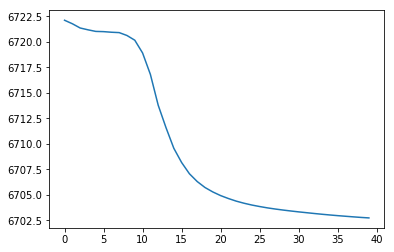

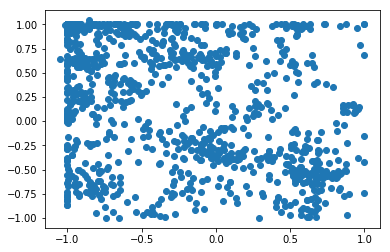

In [80]:
plt.plot(list(range(len(losses))), losses)
plt.show()

plt.plot(z[:,0], z[:,1], 'o')
plt.show()